In [3]:
import scanpy as sc

adata = sc.read_h5ad("/home/jhaberbe/Projects/indian-buffet-process/data/16APR2025.h5ad")
adata = adata[adata.obs["cell_type"].eq("Microglia-PVM") & adata.obs["folder"].eq("99-15")]

/home/jhaberbe/Projects/spatial-indian-buffet-process/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [4]:
import torch
import numpy as np
import pandas as pd

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == "cuda":
    print("CUDA Enabled")

def setup_torch_data(adata, specimen_name: str = "folder"):
    X = torch.tensor(adata[:, (adata.X > 0).mean(axis=0) > 0.05].layers["transcript"])
    size_factor = torch.tensor(np.log((adata.X.sum(axis=1) / adata.X.sum(axis=1).mean())))
    folder = torch.tensor(pd.Categorical(adata.obs[specimen_name]).codes).float()
    return X, size_factor, folder

X, size_factor, folder = setup_torch_data(adata, specimen_name="folder")

X = X.to(device)
size_factor = size_factor.to(device)
folder = folder.to(device)
locs = torch.tensor(adata.obs[["x_centroid", "y_centroid"]].values).to(device)

In [ ]:
def b_k(logits):
    v = torch.sigmoid(logits)  # [K]
    cumprod_1mv = torch.cumprod(1 - v, dim=0)
    cumprod_1mv = torch.cat([torch.ones(1, device=v.device), cumprod_1mv[:-1]])
    pi = v * cumprod_1mv
    return pi


In [ ]:
b_k(test)

tensor([1.9159e-01, 3.9428e-02, 7.8089e-03, 7.9875e-03, 2.5879e-03, 1.5741e-03,
        4.7941e-04, 3.3420e-04, 2.9288e-04, 1.4949e-04])

tensor([0.7417, 0.8120, 0.2014, 0.7098, 0.3585, 0.6788, 0.2920, 0.2845, 0.4737,
        0.5906])

<BarContainer object of 10 artists>

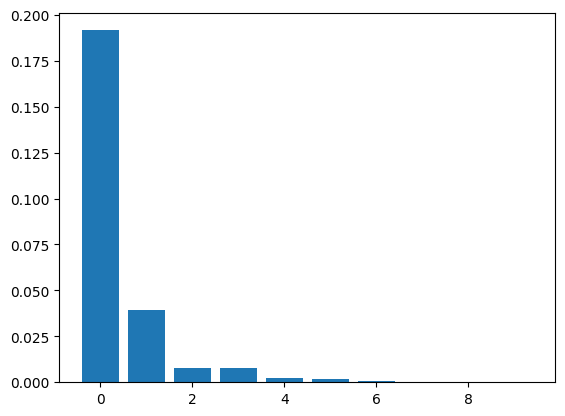

In [ ]:
import matplotlib.pyplot as plt
plt.bar(
    range(10),
    
)

In [ ]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, JitTraceMeanField_ELBO, JitTrace_ELBO
from pyro.optim import ClippedAdam
from gpytorch.kernels import MaternKernel

def model(s, y, folder_ids, size_factors, num_folders, K=10):
    """Pyro model with explicit device handling."""
    # 1. Get device from inputs and validate
    device = s.device
    assert y.device == device, f"y is on {y.device} but should be on {device}"
    assert folder_ids.device == device, f"folder_ids on {folder_ids.device}"
    assert size_factors.device == device, f"size_factors on {size_factors.device}"
    
    N, D = s.shape
    G = y.shape[1]

    # 2. Hyperparameters (explicit device)
    hyper_params = {
        'tau_scale': torch.tensor(2.0, device=device),
        'tau_rate': torch.tensor(2.0, device=device),
        'phi_scale': torch.tensor(2.0, device=device),
        'phi_rate': torch.tensor(2.0, device=device),
        'mu_scale': torch.tensor(2.0, device=device),
        'mu_rate': torch.tensor(2.0, device=device),
        'r_concentration': torch.tensor(2.0, device=device),
        'r_rate': torch.tensor(1.0, device=device)
    }

    # 3. Sample global parameters
    tau = pyro.sample("tau", dist.Gamma(hyper_params['tau_scale'], hyper_params['tau_rate']).expand([1]))
    phi = pyro.sample("phi", dist.Gamma(hyper_params['phi_scale'], hyper_params['phi_rate']).expand([1]))
    mu = pyro.sample("mu", dist.Gamma(hyper_params['mu_scale'], hyper_params['mu_rate']).expand([1]))

    # 4. GP kernel (ensure kernel is on device)
    kernel = MaternKernel(nu=2.5, ard_num_dims=D).to(device)
    kernel.lengthscale = phi

    # 5. Latent GP values
    # Latent GP values - corrected implementation
    cov = kernel(s).evaluate() * (1 / tau)
    with pyro.plate("features", K):
        # Use Independent to properly handle batch dimensions
        f_k = pyro.sample(
            "f_k",
            dist.MultivariateNormal(
                mu * torch.ones(N, device=device),
                covariance_matrix=cov
            )
        )


    # 6. Stick-breaking (verify b_k handles devices)
    pi = b_k(f_k.T.to(device))  # Explicit device

    # 7. Feature activations
    with pyro.plate("data", N):
        z = pyro.sample("z", dist.Bernoulli(pi).to_event(1))

    # 8. Global weights
    W = pyro.sample("W", dist.Normal(
        torch.zeros(K, G, device=device),
        torch.ones(K, G, device=device)
    ).to_event(2))

    # 9. Folder terms
    with pyro.plate("folders", num_folders):
        folder_logits = pyro.sample("folder_logits", dist.Normal(
            torch.zeros(num_folders, G, device=device),
            torch.ones(num_folders, G, device=device)
        ).to_event(2))

    # 10. Dispersion
    r = pyro.sample("r", dist.Gamma(
        hyper_params['r_concentration'],
        hyper_params['r_rate']
    ).expand([G]).to_event(1))

    # 11. Logits computation (triple-check devices)
    linear_term = z @ W
    folder_term = folder_logits[folder_ids.to(device).long()]  # Force device and type
    size_term = (size_factors.to(device) + 1e-6).unsqueeze(-1)

    # # Add this right before your NegativeBinomial sampling
    # print("NaN check:")
    # print(f"linear_term: {torch.isnan(linear_term).any().item()}")
    # print(f"folder_term: {torch.isnan(folder_term).any().item()}")
    # print(f"size_term: {torch.isnan(size_term).any().item()}")
    
    # print(f"r: {torch.isnan(r).any().item()}")

    logits = linear_term + folder_term + size_term
    logits = torch.clamp(logits, -20, 20)  # Additional safety

    # 12. Final likelihood with validation
    pyro.sample("obs", dist.NegativeBinomial(
        total_count=r,
        logits=logits
    ).to_event(2), obs=y.to(device))  # Final safety

In [36]:
import pyro
import pyro.distributions as dist
import torch
import torch.nn.functional as F

def guide(s, y, folder_ids, size_factors, num_folders, K=10):
    device = s.device
    N, D = s.shape
    G = y.shape[1]

    with pyro.plate("features", K):
        f_k_loc = pyro.param("f_k_loc", torch.randn(K, N, device=device))
        pyro.sample(
            "f_k",
            dist.Normal(f_k_loc, 1).to_event(1)  # Using Normal instead of Delta
        )

    # 1. Variational distributions for GP hyperparameters
    # tau ~ Gamma(concentration, rate)
    tau_concentration = pyro.param(
        "tau_concentration", 
        torch.tensor(2.0, device=device), 
        constraint=dist.constraints.positive
    )
    tau_rate = pyro.param(
        "tau_rate", 
        torch.tensor(2.0, device=device), 
        constraint=dist.constraints.positive
    )
    pyro.sample("tau", dist.Gamma(tau_concentration, tau_rate))

    # phi ~ Gamma(concentration, rate)
    phi_concentration = pyro.param(
        "phi_concentration", 
        torch.tensor(2.0, device=device), 
        constraint=dist.constraints.positive
    )
    phi_rate = pyro.param(
        "phi_rate", 
        torch.tensor(2.0, device=device), 
        constraint=dist.constraints.positive
    )
    pyro.sample("phi", dist.Gamma(phi_concentration, phi_rate))

    # mu ~ Gamma(concentration, rate)
    mu_concentration = pyro.param(
        "mu_concentration", 
        torch.tensor(2.0, device=device), 
        constraint=dist.constraints.positive
    )
    mu_rate = pyro.param(
        "mu_rate", 
        torch.tensor(2.0, device=device), 
        constraint=dist.constraints.positive
    )
    pyro.sample("mu", dist.Gamma(mu_concentration, mu_rate))

    # Global weights W [K, G]
    W_loc = pyro.param("W_loc", torch.randn(K, G, device=device))
    W_scale = pyro.param("W_scale", 
                         torch.ones(K, G, device=device), 
                         constraint=dist.constraints.positive)
    W_scale = torch.clamp(W_scale, min=1e-6, max=1.0)  # Prevent exploding variance                        
    pyro.sample("W", dist.Normal(W_loc, W_scale).to_event(2))

    # Folder-specific logits [num_folders, G]
    folder_logits_loc = pyro.param("folder_logits_loc", 
                                  torch.zeros(num_folders, G, device=device))
    folder_logits_scale = pyro.param("folder_logits_scale", 
                                    torch.ones(num_folders, G, device=device),
                                    constraint=dist.constraints.positive)
    pyro.sample("folder_logits", dist.Normal(folder_logits_loc, folder_logits_scale).to_event(2))

    # Dispersion per count variable [G]
    r_alpha = pyro.param("r_alpha", 
                         torch.ones(G, device=device), 
                         constraint=dist.constraints.positive)
    r_beta = pyro.param("r_beta", 
                        torch.ones(G, device=device), 
                        constraint=dist.constraints.positive)
    pyro.sample("r", dist.Gamma(r_alpha, r_beta).to_event(1))

    # Amortized variational distribution over z [N, K]
    logits_z = pyro.param("z_logits", torch.randn(N, K, device=device))
    probs_z = torch.sigmoid(logits_z)
    with pyro.plate("data", N):
        pyro.sample("z", dist.Bernoulli(probs_z).to_event(1))

In [37]:
import pyro
import pyro.optim as optim
from pyro.infer import SVI, Trace_ELBO

# Assume model and guide are already defined, as above

optimizer = optim.ClippedAdam({"lr": 1e-2, "clip_norm": 5.0})

svi = SVI(
    model=model,
    guide=guide,
    optim=optimizer,
    loss=Trace_ELBO(),
)


In [ ]:
num_steps = 100_000
losses = []

pyro.clear_param_store()

import wandb
wandb.init(project="spatial-indian-buffet-process", name="99-15-2")

for step in range(num_steps):
    loss = svi.step(locs, X, folder, size_factor, 1, K=100)
    wandb.log({
        "loss": loss,
        "average_logit": dict(pyro.get_param_store())["z_logits"].mean().item(),
        "percentage_above_zero": (dict(pyro.get_param_store())["z_logits"] > 0).float().mean().item(),
    })
    if step % 100 == 0:
        print(f"[{step}] ELBO loss: {loss:.2f}")


wandb: Currently logged in as: jhaberbe (kibr) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


[0] ELBO loss: 5797049.66
[100] ELBO loss: 3504805.97
[200] ELBO loss: 3150768.00
[300] ELBO loss: 3092380.18
[400] ELBO loss: 3018088.43
[500] ELBO loss: 3131968.47
[600] ELBO loss: 2853130.74
[700] ELBO loss: 2924567.19
[800] ELBO loss: 2891375.75
[900] ELBO loss: 2861174.75
[1000] ELBO loss: 3010503.87
[1100] ELBO loss: 2977943.56
[1200] ELBO loss: 2858315.76
[1300] ELBO loss: 2831150.33
[1400] ELBO loss: 2944390.02
[1500] ELBO loss: 3995204.99
[1600] ELBO loss: 3000189.80
[1700] ELBO loss: 3084456.36
[1800] ELBO loss: 2852452.75
[1900] ELBO loss: 2892142.14
[2000] ELBO loss: 2913687.67
[2100] ELBO loss: 2909935.02
[2200] ELBO loss: 2927870.06
[2300] ELBO loss: 2979228.75
[2400] ELBO loss: 2907797.14
[2500] ELBO loss: 2962397.20
[2600] ELBO loss: 2868072.99
[2700] ELBO loss: 2960882.69
[2800] ELBO loss: 2885797.88
[2900] ELBO loss: 2844116.28
